In [52]:

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as linalg
import pandas as pd

from scipy.special import logsumexp
from scipy.special import softmax
from scipy.stats import invwishart
from scipy.stats import dirichlet
from scipy.stats import multivariate_normal

from sklearn.cluster import KMeans
from sklearn import metrics
import scipy.sparse as sparse

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mode

import random

In [2]:
import numpy as np

In [3]:
random_seed = 123
rng = np.random.default_rng(random_seed)

# 1 Import Dataset

In [22]:
dirpath = "./../../Datasets/Gaussian/Processed/IRIS/"
X_train = np.load(dirpath + "X_train_iris.npy")
y_train = np.load(dirpath + "y_train_iris.npy")

In [5]:
def compute_posterior( X, zs, μs, Σs, πs,m_0, α_0,k_0,S_0,v_0):
    N,D = X.shape
    K,_ = μs.shape

    comp_prior = dirichlet.logpdf(πs,α_0)
    cat_prior = np.sum(np.log(πs[zs]))

    param_prior = 0.0
    for k in range(K):
        μ = μs[k]
        Σ = Σs[k]

        mean_prior   = multivariate_normal.logpdf(μ, mean=m_0, cov=(1/k_0)*Σ)
        cov_prior    = invwishart.logpdf(Σ, df=v_0, scale=S_0)

        param_prior += mean_prior + cov_prior

    log_likelihood = 0.0
    for n in range(N):
        k = zs[n]
        μ = μs[k]
        Σ = Σs[k]
        log_likelihood += multivariate_normal.logpdf(X[n], mean=μ, cov=Σ)

    posterior_prob = comp_prior + cat_prior + param_prior + log_likelihood

    return posterior_prob

In [ ]:
import numpy as np
from scipy.optimize import linear_sum_assignment
import copy

def hungarian_permutation(z_ref, z_new, K):
    """Find best label permutation to match z_new to z_ref."""
    cost_matrix = np.zeros((K, K))
    for i in range(K):
        for j in range(K):
            cost_matrix[i, j] = -np.sum((z_new == i) & (z_ref == j))
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    perm = col_ind[np.argsort(row_ind)]
    return perm

def relabel_sample(sample, perm):
    """Apply label permutation to one Gibbs sample."""
    sample = copy.deepcopy(sample)
    sample['z'] = np.array([perm[label] for label in sample['z']])
    sample['μ'] = sample['μ'][perm]
    sample['Σ'] = sample['Σ'][perm]
    sample['π'] = sample['π'][perm]
    return sample

def relabel_all_samples(samples, K, best_idx=0):
    """Align all samples to the labeling of sample[best_idx] using Hungarian algorithm."""
    # z_ref = samples[best_idx]['z']
    z_ref = mode([s['z'] for s in samples], axis=0).mode[0]
    aligned_samples = []

    for t, sample in enumerate(samples):
        perm = hungarian_permutation(z_ref, sample['z'], K)
        aligned_sample = relabel_sample(sample, perm)
        aligned_samples.append(aligned_sample)

    return aligned_samples


# 2 Un-Collapsed Gibbs

1) Initialize $\mathbf{z}, \boldsymbol{\mu}, \boldsymbol{\Sigma}, \boldsymbol{\pi}$
2) For $t=0,...,T$
$$\begin{align}
    \text{Sample } \boldsymbol{\pi}^{(t)} &\sim p(\boldsymbol{pi} | \mathbf{z}^{(t-1)}) = \mathrm{Dirichlet}(\boldsymbol{\alpha}_N^{(t-1)}),\\
    &\boldsymbol{\alpha}_N^{(t-1)} = \left[\alpha_0^1 + n_1,\, \alpha_0^2 + n_2,\, \dots,\, \alpha_0^K + n_K \right],
        \quad \text{where} \quad
        n_k^{(t-1)} = \sum_{i=1}^N \mathbb{1}(z_i^{(t-1)} = k) \\\\

    \text{Sample } \boldsymbol{\Sigma}^{(t)}, &\boldsymbol{\mu}^{(t)} \sim p(\boldsymbol{\Sigma},\boldsymbol{\mu}|\mathbf{z}^{(t-1)}, \mathbf{X})\\
     &= \prod_k^K \mathrm{NIW}(\mu,\Sigma | \mathbf{m}_N, \kappa_N, \nu_N, \mathbf{S}_N) =  \prod_k^K \mathrm{N}(\mu|\mathbf{m}_N, \frac{1}{\kappa_N}\Sigma) \times \mathrm{IW}(\Sigma | \mathbf{S}_N, \nu_N),\\
        &\qquad\qquad \mathbf{m}_{N_k} = \frac{\kappa_{0_k}m_{0_k} + N_k\bar{\mathbf{x}}_k}{\kappa_{0_k} + N_k}\\
        &\qquad\qquad \kappa_{N_k} = \kappa_{0} + N_k\\
        &\qquad\qquad \nu_{N_k} = \nu_{0} + N_k\\
        &\qquad\qquad \mathbf{S}_{N_k} = \mathbf{S}_{0_k} + \mathbf{S}_{\bar{\mathbf{x}}_k} + \frac{\kappa_{0_k}N_k}{\kappa_{0_k} + N_k}(\bar{\mathbf{x}}_k - m_{0_k})(\bar{\mathbf{x}}_k - m_{0_k})^T\\\\

    \text{Sample } \mathbf{z}^{(t)} \sim &P(\mathbf{z}|\mathbf{X},\boldsymbol{\pi}^{(t)}, \boldsymbol{\theta}^{(t)})\\

        \text{For } i &\in {1,..,N}\\
            &\text{Sample } z_i^{(t)} \sim \text{Categorical}(p_1^{(i)},...,p_K^{(i)}) \quad \text{where,}\\
                &\qquad p_k^{(i)} \propto \pi_k^{(t)} \mathcal{N}(\mathbf{x}_i|\boldsymbol{\mu}_k^{(t)},\boldsymbol{\Sigma}_k^{(t)})\\\\
\end{align}$$

In [7]:
def gaussian_likelihood(X, μ, Σ, π):
    N,D = X.shape
    K = π.shape[0]
    
    logp = np.zeros((N,K))

    for k in range(K):
        logp[:,k] = np.log(π[k]) + multivariate_normal.logpdf(X, mean=μ[k],cov=Σ[k])

    log_norm = logsumexp(logp,axis=1,keepdims=True)

    p = np.exp(logp - log_norm)

    loglik = np.sum(log_norm)/N

    return p,loglik

In [8]:
def sampleZs(p):
    ''' 
        Samples cluster assignments z for n datapoints 

        @param (p) : softmax categorical probabilities over clusters (N, K)
    '''

    # Inverse sample from categorical distribution
    cdf = np.cumsum(p, axis=1) # compute CDF for each row (each categorical distribution)
    u   = rng.random(size=(p.shape[0], 1))
    return (cdf > u).argmax(axis=1)  # return first index where cdf is greater than random u

In [9]:
def sample_π(zs, α_0, K):
    ''' 
        Samples mixing weights from Dirichlet distribution parameterized by pseudocounts of components
        
        @param (zs)  : cluster assignments (n)
        @param (α_0) : Dirichlet prior list (K)
        @param (K)   : the number of components
    '''

    z_counts = np.bincount(zs.astype(np.int64), minlength=K)
    return rng.dirichlet(α_0 + z_counts)

In [10]:
def sample_NIW(X,zs,μ_0,S_0,k_0,ν_0,K):
    N,D = X.shape

    zs_hot = np.eye(K)[zs.astype(int)]
    counts = np.bincount(zs.astype(int), minlength=K)[:, None] # component cardinality 
    nonzero = counts.ravel() > 0 
    x_bar = np.zeros((K, D))
    np.divide(zs_hot.T @ X, counts, out=x_bar, where=nonzero[:, None])

    Σs = np.zeros((K,D,D))
    μs = np.zeros((K,D))

    for k in range(K):
        indices = (zs == k)
        n_k = np.sum(indices)
        k_n = k_0 + n_k

        X_k = X[indices]
        S = (X_k - x_bar[k]).T @ (X_k - x_bar[k])
        diff = (x_bar[k] - μ_0).reshape(-1,1)
        S_n = S_0 + S + ((k_0 * n_k)/(k_n)) * (diff @ diff.T)
        Σs[k] = invwishart.rvs(df=ν_0 + n_k, scale=S_n)


        μ_n = (k_0 * μ_0 + n_k * x_bar[k])/k_n
        μs[k] = np.random.multivariate_normal(mean=μ_n, cov=Σs[k]/k_n)
        
    return Σs,μs

In [ ]:
def gibbs(X, num_iter, num_burn, K, rng=np.random.default_rng(random_seed)) :
    N,D = X.shape

    πs = []
    zs = []
    Σs = []
    μs = []

    # Intialize
    α_0 = np.full(K, 1 / K)  # Dirichlet
    k_0 = 0.01         # Prior confidence in μ_0
    μ_0 = np.zeros((D))  # Prior mean vector 
    ν_0 = D + 1        # DOF for inverse wishart
    S_0 = np.eye(D) * 1e-3# prior scatter matrix

    π = rng.dirichlet(α_0)
    z = np.random.randint(0,K,size=N)
    Σ,μ = sample_NIW(X,z,μ_0,S_0,k_0,ν_0,K)

    likelihoods = []

    post = []

    for t in range(1,num_iter+num_burn):
        π = sample_π(z, α_0, K)
        Σ,μ = sample_NIW(X,z,μ_0,S_0,k_0,ν_0,K)
        p, loglik = gaussian_likelihood(X,μ,Σ,π)

        z = sampleZs(p)

        posterior_likelihood = compute_posterior(X, z, μ, Σ, π,μ_0,α_0,k_0,S_0,ν_0)

        if t >= num_burn:
            post.append(posterior_likelihood)
            likelihoods.append(loglik)
            zs.append(z.copy())
            πs.append(π.copy())
            μs.append(μ.copy())
            Σs.append(Σ.copy())

    return zs, Σs, μs, πs,likelihoods, post

In [23]:
zs,sigmas,mus,pis,likelihoods,post = gibbs(X_train,4000,1000,3)

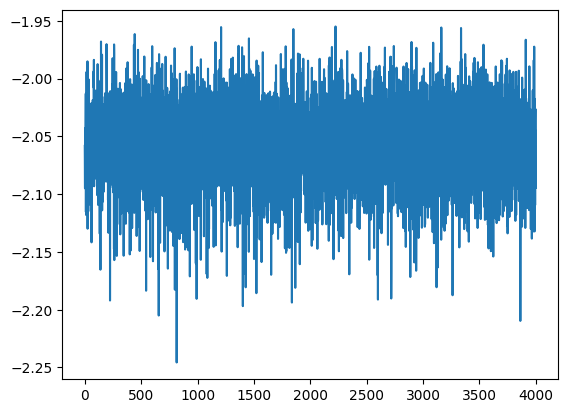

In [29]:
plt.plot(likelihoods)

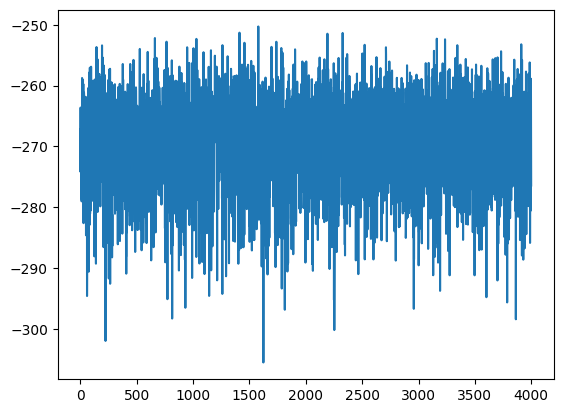

In [30]:
plt.plot(post)

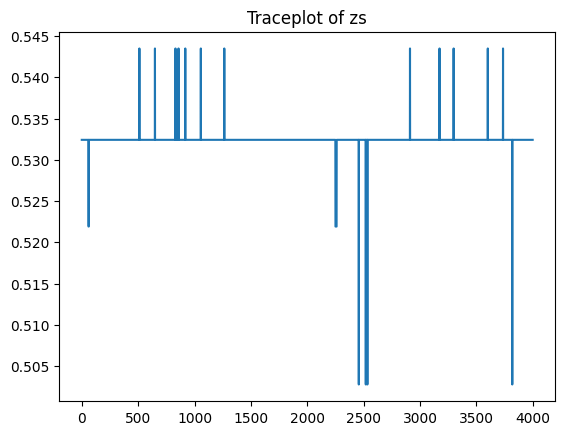

In [31]:
scores = [metrics.adjusted_rand_score(y_train, zs[i]) for i in range(0,len(zs))]
plt.plot(scores)
plt.title("Traceplot of zs")
plt.show()

In [273]:
max_idx = np.argmax(post)
best_zs = scores[max_idx]
best_mu = scores[max_idx]
best_sigma = scores[max_idx]
best_pi = scores[max_idx]
print(scores[max_idx])

0.5672727272727273


In [24]:
samples =[]
for i in range(len(post)):
    samples.append({
        'π' : pis[i],
        'z': zs[i],
        'μ': mus[i],
        'Σ': sigmas[i],
    })

In [25]:
aligned_samples = relabel_all_samples(samples,3)

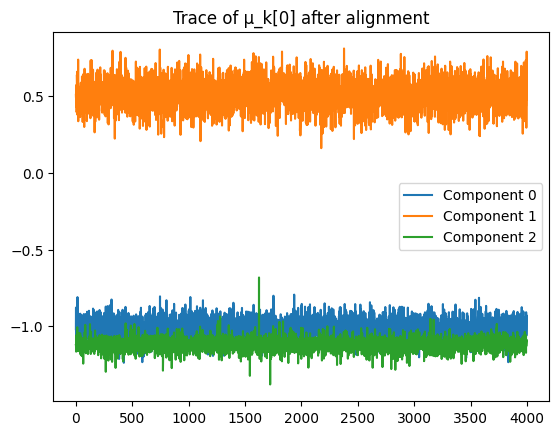

In [33]:
import matplotlib.pyplot as plt

for k in range(3):
    trace = [sample['μ'][k, 0] for sample in aligned_samples]  # dim 0 of μ_k
    plt.plot(trace, label=f'Component {k}')
plt.title("Trace of μ_k[0] after alignment")
plt.legend()
plt.show()


In [26]:
mus = [o['μ'] for o in aligned_samples]

In [39]:
X_train = np.load("./../../Datasets/Gaussian/Processed/synthetic/X_train_synthetic.npy")
y_train = np.load("./../../Datasets/Gaussian/Processed/synthetic/y_train_synthetic.npy")

In [40]:
zs,sigmas,mus,pis,likelihoods,post = gibbs(X_train,1000,250,5)

In [41]:
metrics.adjusted_rand_score(zs[-1],y_train)

1.0

In [56]:
samples =[]
for i in range(len(post)):
    samples.append({
        'π' : pis[i],
        'z': zs[i],
        'μ': mus[i],
        'Σ': sigmas[i],
    })

aligned_samples = relabel_all_samples(samples,5)

In [57]:
means = np.load("./../../Datasets/Gaussian/Processed/synthetic/means_synthetic.npy")

In [58]:
print(means)

[[  6.73387529   6.27895009  12.62320647  33.49594926   7.15665244]
 [  3.07739503  19.73490184 -14.53564144 -21.41869735 -20.87641278]
 [-23.48273284  13.93187344   6.76065521 -27.73564894  28.17386305]
 [ 14.30985266   2.23355958   2.65616853  21.74997254  17.88337126]
 [-26.9437501  -37.91861001 -20.57854805   3.38591362 -18.12874469]]


In [59]:
aligned_means = np.mean([s['μ'] for s in aligned_samples], axis=0)
print(aligned_means)

[[ 14.1577003    2.36598333   2.60983091  21.54019829  17.78077248]
 [  3.19328123  19.81527337 -14.35364917 -21.55120767 -20.96540823]
 [-26.80842794 -37.88961001 -20.54709331   3.46833405 -18.08989218]
 [  6.91747273   6.18451067  12.50268556  33.42841166   7.17757124]
 [-23.76653103  13.88227159   6.68406277 -27.81848329  28.37109171]]


In [51]:
metrics.adjusted_rand_score(aligned_samples[-1]['z'], y_train)

1.0

# 2 Missing Data with Data Sampling

1) Initialize $\mathbf{z}, \boldsymbol{\mu}, \boldsymbol{\Sigma}, \boldsymbol{\pi}$
2) For $t=0,...,T$
$$\begin{align}
    \text{Sample } \boldsymbol{\pi}^{(t)} &\sim p(\boldsymbol{pi} | \mathbf{z}^{(t-1)}) = \mathrm{Dirichlet}(\boldsymbol{\alpha}_N^{(t-1)}),\\
    &\boldsymbol{\alpha}_N^{(t-1)} = \left[\alpha_0^1 + n_1,\, \alpha_0^2 + n_2,\, \dots,\, \alpha_0^K + n_K \right],
        \quad \text{where} \quad
        n_k^{(t-1)} = \sum_{i=1}^N \mathbb{1}(z_i^{(t-1)} = k) \\\\

    \text{Sample } \boldsymbol{\Sigma}^{(t)}, &\boldsymbol{\mu}^{(t)} \sim p(\boldsymbol{\Sigma},\boldsymbol{\mu}|\mathbf{z}^{(t-1)}, \mathbf{X})\\
     &= \prod_k^K \mathrm{NIW}(\mu,\Sigma | \mathbf{m}_N, \kappa_N, \nu_N, \mathbf{S}_N) =  \prod_k^K \mathrm{N}(\mu|\mathbf{m}_N, \frac{1}{\kappa_N}\Sigma) \times \mathrm{IW}(\Sigma | \mathbf{S}_N, \nu_N),\\
        &\qquad\qquad \mathbf{m}_{N_k} = \frac{\kappa_{0_k}m_{0_k} + N_k\bar{\mathbf{x}}_k}{\kappa_{0_k} + N_k}\\
        &\qquad\qquad \kappa_{N_k} = \kappa_{0} + N_k\\
        &\qquad\qquad \nu_{N_k} = \nu_{0} + N_k\\
        &\qquad\qquad \mathbf{S}_{N_k} = \mathbf{S}_{0_k} + \mathbf{S}_{\bar{\mathbf{x}}_k} + \frac{\kappa_{0_k}N_k}{\kappa_{0_k} + N_k}(\bar{\mathbf{x}}_k - m_{0_k})(\bar{\mathbf{x}}_k - m_{0_k})^T\\\\

    \text{Sample } \mathbf{X} \sim  p(&\mathbf{\mathbf{X}|\boldsymbol{z}^{(t-1)},\boldsymbol{\Sigma}^{(t)}, \boldsymbol{\mu}^{(t)}})\\
        \text{For } i &\in {1,..,N}\\
             &\text{Sample } \mathbf{x}_{i,H} \sim p(\mathbf{x}_{i,H}|\mathbf{x}_{i,O}, \mathbf{z}_i = k, \boldsymbol{\mu}_k^{(t)}, \boldsymbol{\Sigma}_k^{(t)}) = \mathcal{N}(\mathbf{m}_i,V_i),\quad \text{where} \\
                &\qquad \mathbf{m}_i = \boldsymbol{\mu}_H + \boldsymbol{\Sigma}_{H,O}\boldsymbol{\Sigma}_{O,O}^{-1}(\mathbf{x}_{i,O} - \boldsymbol{\mu}_O)\\
                &\qquad V_i = \boldsymbol{\Sigma}_{H,H} - \boldsymbol{\Sigma}_{H,O}\boldsymbol{\Sigma}_{O,O}^{-1}\boldsymbol{\Sigma}_{O,H}\\\\

    \text{Sample } \mathbf{z}^{(t)} \sim &P(\mathbf{z}|\mathbf{X},\boldsymbol{\pi}^{(t)}, \boldsymbol{\theta}^{(t)})\\

        \text{For } i &\in {1,..,N}\\
            &\text{Sample } z_i^{(t)} \sim \text{Categorical}(p_1^{(i)},...,p_K^{(i)}) \quad \text{where,}\\
                &\qquad p_k^{(i)} \propto \pi_k^{(t)} \mathcal{N}(\mathbf{x}_i|\boldsymbol{\mu}_k^{(t)},\boldsymbol{\Sigma}_k^{(t)})\\\\
\end{align}$$

Missing Data Conditional Sampling 

$$\begin{align}
    \mathbf{x}_{i,H} | \mathbf{x}_{i,O}& \sim \mathcal{N}(\mathbf{m}_i, V_i)\\\\
        \mathbf{m}_i &= \boldsymbol{\mu}_H + \boldsymbol{\Sigma}_{H,O}\boldsymbol{\Sigma}_{O,O}^{-1}(\mathbf{x}_{i,O} - \boldsymbol{\mu}_O)\\\\
        V_i &= \boldsymbol{\Sigma}_{H,H} - \boldsymbol{\Sigma}_{H,O}\boldsymbol{\Sigma}_{O,O}^{-1}\boldsymbol{\Sigma}_{O,H}

\end{align}$$

In [211]:
def gaussian_likelihood1(X, μs, Σs, πs, missing_mask):
    N, D = X.shape
    K,_ = μs.shape

    logprobs = np.zeros((N,K))

    missing = np.any(missing_mask)

    for k in range(K):
        μ = μs[k]
        Σ = Σs[k]
        π = πs[k]

        if (not missing) : 
            logprobs[:,k] = np.log(π) + multivariate_normal.logpdf(X, mean=μ, cov=Σ)
            continue

        for i in range(N):
            miss_mask = missing_mask[i]
            obs_mask = ~miss_mask

            x_o = X[i][obs_mask]
            μ_o  = μ[obs_mask]
            Σ_oo = Σ[np.ix_(obs_mask, obs_mask)]

            logprobs[i,k] = np.log(π) + multivariate_normal.logpdf(x_o, mean=μ_o, cov=Σ_oo)

    log_norm = logsumexp(logprobs, axis=1, keepdims=True)
    loglike = np.sum(log_norm)/N
    p = np.exp(logprobs - log_norm)

    return p, loglike

In [10]:
# With conditioning on observed pixels 
def sampleXsConditional(X, zs, μs, Σs, missing_mask):
    N, D = X.shape
    
    X_sample = X.copy()

    for i in range(N):
        k = zs[i].astype(int)
        μ = μs[k]
        Σ = Σs[k]

        miss_mask = missing_mask[i]
        obs_mask = ~miss_mask

        μ_h = μ[miss_mask]
        μ_o = μ[obs_mask]
        Σ_oh = Σ[obs_mask][:, miss_mask]
        Σ_ho = Σ[miss_mask][:, obs_mask]
        Σ_oo = Σ[obs_mask][:, obs_mask]
        Σ_hh = Σ[miss_mask][:, miss_mask]

        m_i = μ_h + Σ_ho @ np.linalg.inv(Σ_oo) @ (X[i,obs_mask] - μ_o)
        V_i = Σ_hh - Σ_ho @ np.linalg.inv(Σ_oo) @ Σ_oh

        X_sample[i,miss_mask] = np.random.multivariate_normal(m_i,V_i)

    return X_sample


In [157]:
# With conditional independence assumption (unconditioned on observed features)
def sampleXsIID(X, zs, μs, Σs, missing_mask):
    N, D = X.shape
    X_sample = X.copy()

    for i in range(N):
        k = zs[i].astype(int)
        μ = μs[k]
        Σ = Σs[k]
        sample =  rng.multivariate_normal(μ,Σ)
        X_sample[i, missing_mask[i]]  =sample[missing_mask[i]]

    return X_sample


In [11]:
def mean_impute(X,missing_mask):
    X_0 = X.copy()
    means = np.nanmean(np.where(missing_mask, np.nan, X), axis=0)
    X_0[missing_mask] = np.take(means, np.where(missing_mask)[1])
    return X_0

In [12]:
def gibbs_missing(X, num_iter, num_burn,K, iid=False, rng=np.random.default_rng(random_seed), eps=1e-20) :
    N,D = X.shape

    logliks = []

    missing_mask = np.isnan(X)

    πs = []
    zs = []
    Σs = []
    μs = []
    xs = []

    # Intialize
    α_0 = np.full(K, 1 / K)  # Dirichlet
    k_0 = 0.01         # Prior confidence in μ_0
    μ_0 = np.zeros(D)  # Prior mean vector 
    ν_0 = D + 1        # DOF for inverse wishart
    S_0 = np.eye(D)# prior scatter matrix

    π = rng.dirichlet(α_0)
    z = np.random.randint(0,K,size=N)
    x = mean_impute(X,missing_mask)
    Σ,μ = sample_NIW(x,z,μ_0,S_0,k_0,ν_0,K)

    for t in range(1,num_iter+num_burn):
        π = sample_π(z, α_0, K)

        if (iid) : 
            x = sampleXsIID(X,z,μ,Σ,missing_mask)
        else :
            x = sampleXsConditional(X,z,μ,Σ,missing_mask)

        Σ,μ = sample_NIW(x,z,μ_0,S_0,k_0,ν_0,K)

        # p, loglik = gaussian_likelihood1(X,μ,Σ,π, missing_mask)
        p, loglik = gaussian_likelihood(x,μ,Σ,π)

        z = sampleZs(p)

        if t > num_burn:
            πs.append(π.copy())
            zs.append(z.copy())
            Σs.append(Σ.copy())
            μs.append(μ.copy())
            xs.append(x.copy())
            logliks.append(loglik)

    return zs, Σs, μs, πs, logliks

In [13]:
import random
N,D = X_train.shape
X_cover1 = np.empty_like(X_train, dtype='f')
X_cover1[:] = X_train
for i in range(0,len(X_cover1)):
    indices = random.sample(range(0,D), D//2)
    X_cover1[i][indices] = np.nan

In [14]:
zs,Σs,μs,πs,logliks= gibbs_missing(X_cover1, 1000, 250, iid=False,K=3)

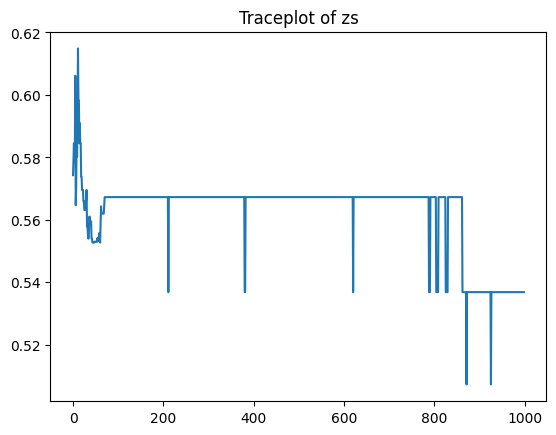

In [15]:
scores = [metrics.adjusted_rand_score(y_train, zs[i]) for i in range(0,len(zs))]
plt.plot(scores)
plt.title("Traceplot of zs")
plt.show()

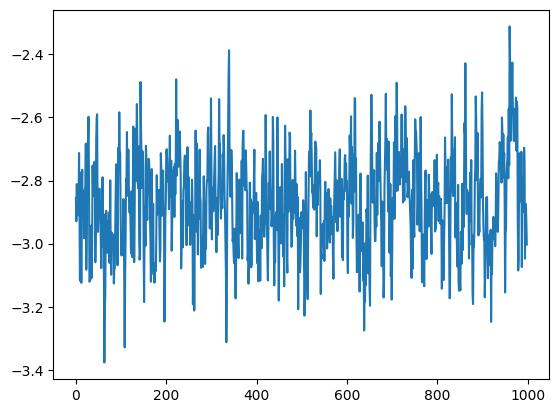

In [232]:
plt.plot(logliks)

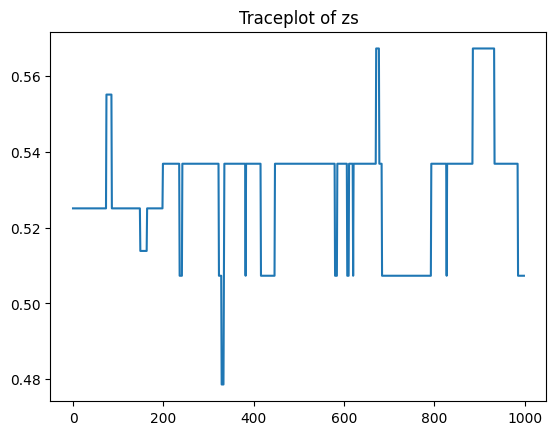

In [231]:
scores = [metrics.adjusted_rand_score(y_train, zs[i]) for i in range(0,len(zs))]
plt.plot(scores)
plt.title("Traceplot of zs")
plt.show()

In [111]:
zs,Σs,μs,πs,logliks= gibbs_missing(X_cover1, 100, 25, iid=True,K=3)

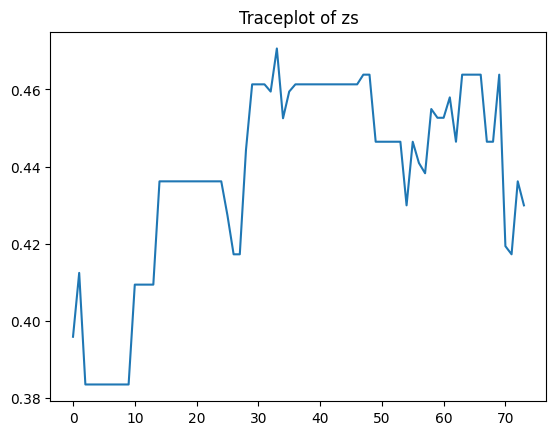

In [112]:
scores = [metrics.adjusted_rand_score(y_train, zs[i]) for i in range(0,len(zs))]
plt.plot(scores)
plt.title("Traceplot of zs")
plt.show()